#  Multi-Site Infant Brain Segmentation using Cascading U-Nets

This notebook implements an algorithm for segmenting brain MRI scans into three key components: skull/cranium, gray matter, and white matter. 

**Prénom**: Alexandre \
**Nom**: Devaux Riviere \
**Login**: alexandre.devaux-riviere

## The iSeg-2019 Challenge dataset

To download the data check the following link: https://iseg2017.web.unc.edu/download/

This dataset contains brain MRI scans and segmentations from babies brain / cranium.

**Training set:**
- 10 subjects (1-10)
- Each has T1, T2 MRI and manual segmentation (T1 and T2 are two different MRI scanning techniques that highlight different tissue and we will talk about that later)
- Segmentation labels:
  * **0** : Background
  * **10** : Cranium
  * **150** : Gray Matter (GM)
  * **250** : White Matter  (WM)


**Testing set:**
- 13 subjects (11-23)
- Contains T1 and T2 MRI only

## Understanding MRI Data Perspectives

Brain MRI data is analyzed from three different anatomical planes, each providing different insights:
 - **Sagittal view**: Divides the brain into left and right portions
 - **Coronal view**: Divides the brain into front and back sections
 - **Axial view**: Divides the brain into top and bottom sections

As shown below, we have access to these three views for both T1 and T2 modalities, along with their corresponding ground truth segmentations:

<img src="./visualizations/data.png" width="800" />

# Model architecture overview
 
 This project implements a cascading architecture using three U-Net models:
 1. First U-Net: Skull/cranium segmentation
 2. Second U-Net: Grey matter segmentation (uses skull predictions)
 3. Third U-Net: White matter segmentation (uses both skull and grey matter predictions)

 Each subsequent model builds upon the predictions of previous models to improve accuracy. The final segmentation combines all three predictions into a single output.

![Model Architecture](visualizations/data_models.gif)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
output.no_vertical_scroll()

Mounted at /content/drive


<IPython.core.display.Javascript object>

## Imports - requirements

In [2]:
import numpy as np
import tensorflow as tf
import nibabel as nib

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ReduceLROnPlateau
from matplotlib import pyplot as plt

## Step 1: Sample visualization

In [3]:
def get_patients_path(num_patients=10):
  """Load patient data for T1, T2, and ground truth (GT)"""
  path_T1, path_T2, path_GT = [], [], []
  base_path = "/content/drive/My Drive/health/subject-"

  for x in range(1, num_patients + 1):
    path_T1.append(nib.load(f"{base_path}{x}-T1.img"))
    path_T2.append(nib.load(f"{base_path}{x}-T2.img"))
    path_GT.append(nib.load(f"{base_path}{x}-label.img"))

  return path_T1, path_T2, path_GT

def extract_data_from_path(path_list):
  return [np.squeeze(x.get_fdata()) for x in path_list]

In [4]:
path_T1, path_T2, path_GT = get_patients_path(10)

data_t1 = extract_data_from_path(path_T1)
data_t2 = extract_data_from_path(path_T2)
data_gt = extract_data_from_path(path_GT)

In [5]:
def show_slices(slices):
  """Display a row of image slices"""
  plt.figure(figsize=(12, 12))
  nbslices = len(slices)
  for i, slide in enumerate(slices):
    plt.subplot(1, nbslices, i+1)
    plt.imshow(slide)
    plt.axis('off')
  plt.show()

def show_patient_phases(img_fdata, patient_num):
  """Show different phases of a single patient's scan"""
  x, y, z = img_fdata.shape
  slices = [
        img_fdata[x//2, :, :],
        img_fdata[:, y//2, :],
        img_fdata[:, :, z//2]
    ]
  print(f"Slices of patient {patient_num}")
  show_slices(slices)

def show_each_patients(data_list, limit=None):
  for i, data in enumerate(data_list, 1):
    show_patient_phases(data, i)
    if i == limit:
      break

Slices of patient 1


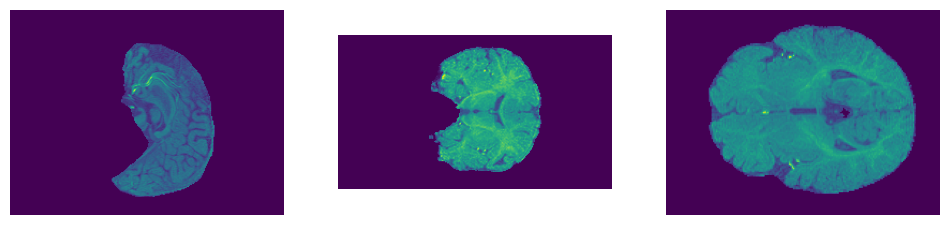

Slices of patient 2


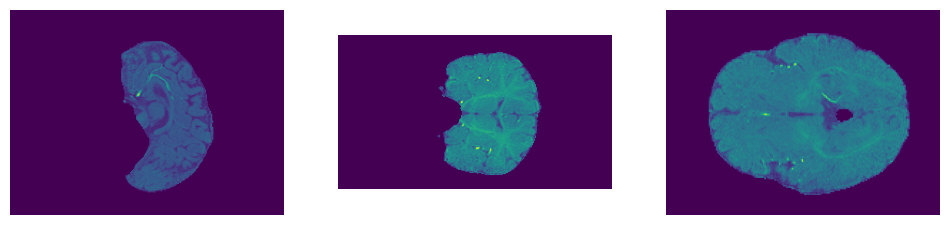

Slices of patient 3


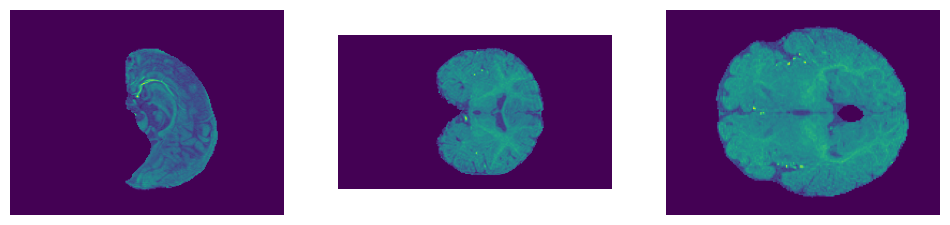

Slices of patient 4


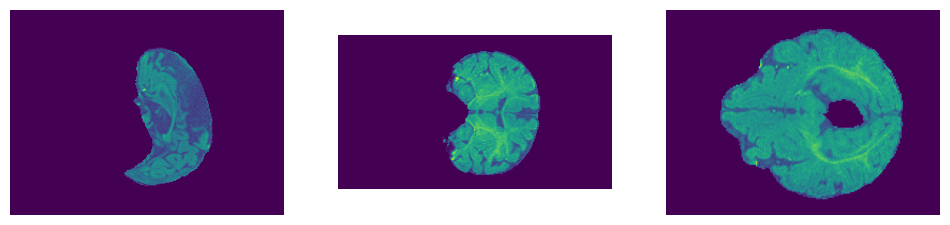

Slices of patient 5


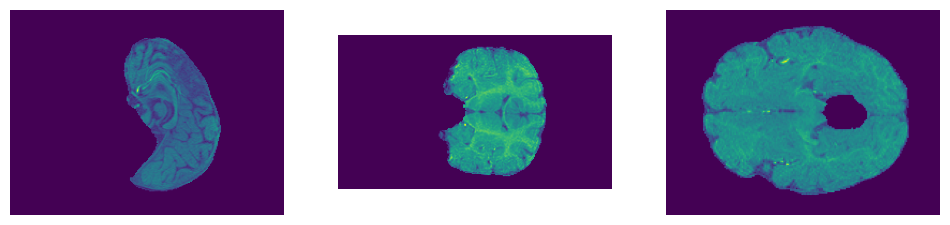

In [6]:
show_each_patients(data_t1, 5)

Slices of patient 1


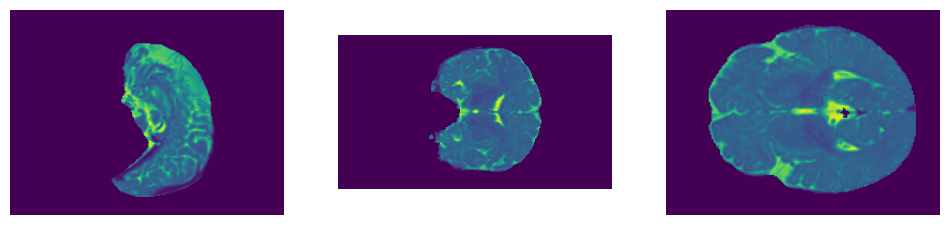

Slices of patient 2


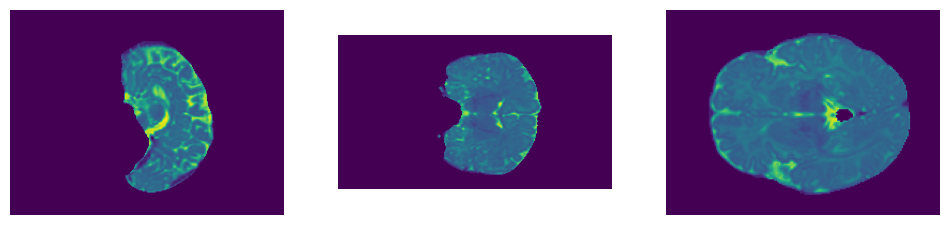

Slices of patient 3


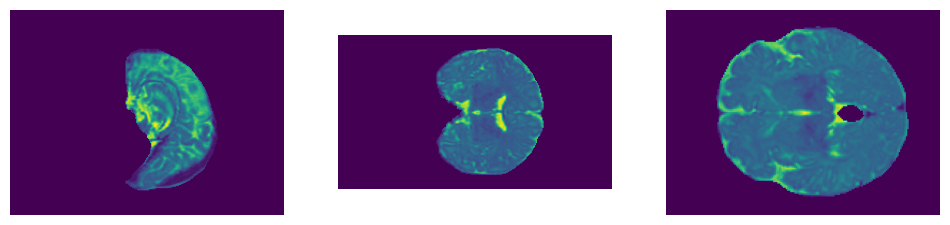

Slices of patient 4


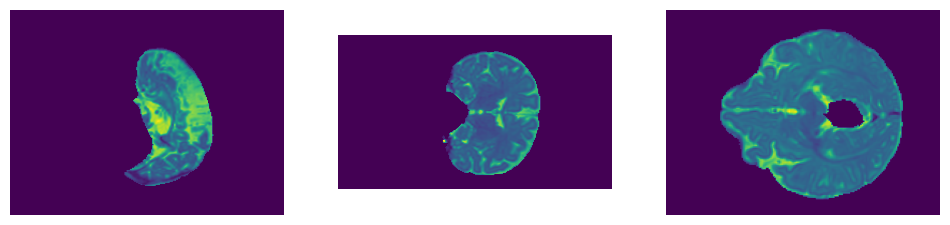

Slices of patient 5


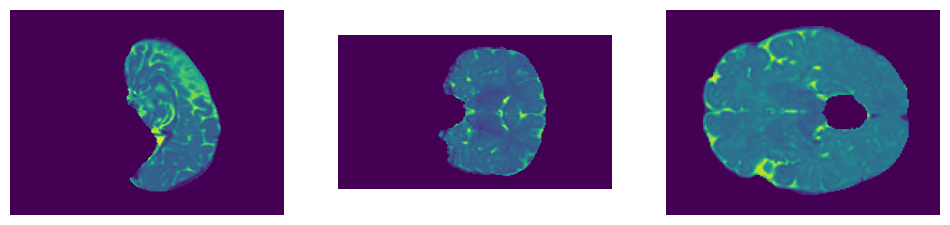

In [7]:
show_each_patients(data_t2, 5)

Slices of patient 1


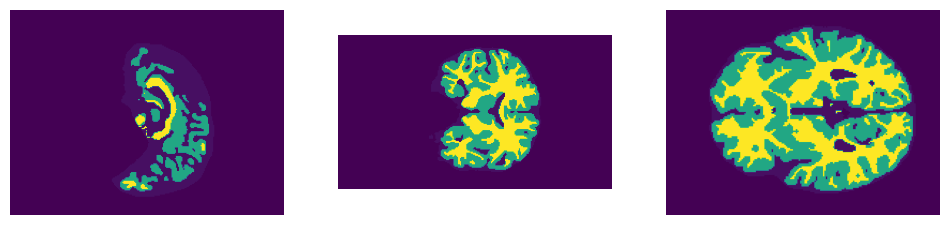

Slices of patient 2


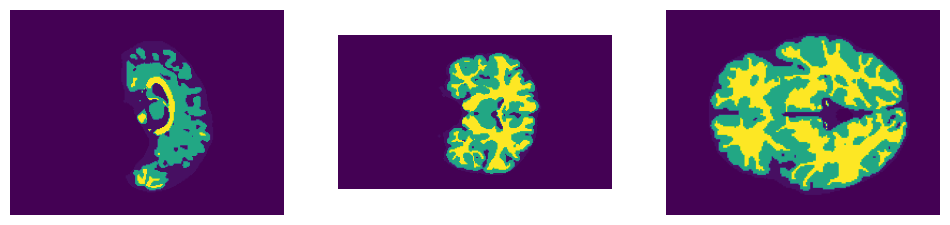

Slices of patient 3


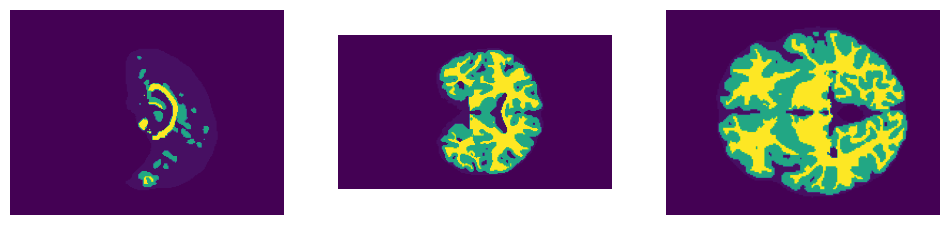

Slices of patient 4


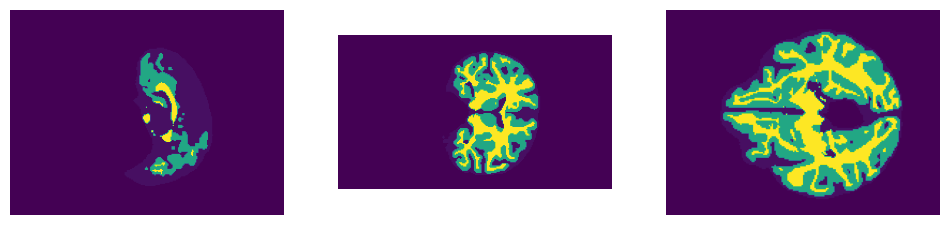

Slices of patient 5


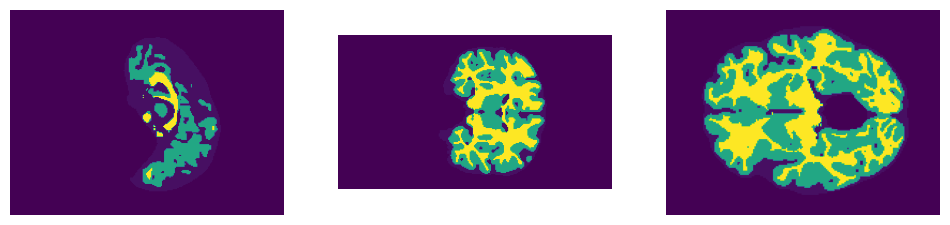

In [8]:
show_each_patients(data_gt, 5)

## Identifying the match between T1 / T2 and GT

Without deep knowledge of grey or white matter, we observe that T1 and T2 images show similarities, although color nuances differ slightly. T1 images show more defined edges, while T2 images offer more marked contrast.

These two types of images, T1 and T2, together contribute to collecting maximum data needed to produce an accurate result, represented by GT.

Definition of T1 and T2 found on the internet:

    T1: Measures hydrogen nuclei recovery time, used to visualize brain structural anatomy.

    T2: Measures hydrogen nuclei coherence loss time, used to detect brain lesions and inflammation.

    ---
    GT: Representing the ideal segmentation we aim to achieve.

# Step 2 : Data normalization and dataset splits

In [9]:
def gaussian_normalize(image):
    positive = image[image > 0]
    mean = np.mean(positive)
    sigma = np.std(positive)
    return (image - mean) / (5 * sigma)

In [10]:
def compute_dice_coef(X, Y):
  """Calculate Dice coefficient between two binary masks"""
  X_bin = X > 0
  Y_bin = Y > 0
  intersection = np.sum(np.logical_and(X_bin, Y_bin))
  total = np.sum(X_bin) + np.sum(Y_bin)
  return 2 * intersection / total if total > 0 else 0

In [11]:
data_t1 = [gaussian_normalize(img) for img in data_t1]
data_t2 = [gaussian_normalize(img) for img in data_t2]

## Split dataset into train / val / test splits

In [12]:
def split_data(data_list, train_end=6, val_end=8):
    return (
        np.array(data_list[:train_end]),
        np.array(data_list[train_end:val_end]),
        np.array(data_list[val_end:])
    )

# Train, Val and Test lists
train_t1, val_t1, test_t1 = split_data(data_t1)
train_t2, val_t2, test_t2 = split_data(data_t2)
train_GT, val_GT, test_GT = split_data(data_gt)

# Step 3: Preprocessing data format for training

In [13]:
def count_valid_slices(data):
    """Count number of valid slices in the dataset"""
    total_slices = 0
    for volume in data:
        for i in range(volume.shape[2]):
            if np.sum(volume[:,:,i] > 0) > 100:
                total_slices += 1
    return total_slices, volume.shape[0], volume.shape[1]

In [14]:
# Count slices for each dataset
nb_slices_train, height, width = count_valid_slices(train_GT)
nb_slices_val, _, _ = count_valid_slices(val_GT)
nb_slices_test, _, _ = count_valid_slices(test_GT)

In [15]:
nb_slices_train, nb_slices_val, nb_slices_test

(599, 199, 196)

In [16]:
def prepare_training_data(t1_data, t2_data, gt_data, num_slices, height, width, channels=2):
    """Prepare training data for the network by filling with 0"""
    X = np.zeros((num_slices, height, width, channels))
    Y = np.zeros((num_slices, height, width))

    n = 0
    for t1, t2, gt in zip(t1_data, t2_data, gt_data):
        for z in range(gt.shape[2]):
            if np.sum(gt[:,:,z] > 0) > 100:
                X[n,:,:,0] = t1[:,:,z]
                X[n,:,:,1] = t2[:,:,z]
                Y[n,:,:] = (gt[:,:,z] > 0).astype(float) # All (cranium, WM, GP)
                n += 1
    return X, Y

In [17]:
X_train, Y_train = prepare_training_data(train_t1, train_t2, train_GT, nb_slices_train, height, width)
X_val, Y_val = prepare_training_data(val_t1, val_t2, val_GT, nb_slices_val, height, width)

### Data normalization and binary masks verification



In [18]:
# labels
print("Y_train unique values:", np.unique(Y_train))
print("Y_val unique values:", np.unique(Y_val), "\n")

# training data
print("X_train value range:", np.min(X_train), "to", np.max(X_train))
print("X_val value range:", np.min(X_val), "to", np.max(X_val))

Y_train unique values: [0. 1.]
Y_val unique values: [0. 1.] 

X_train value range: -0.9787845128676147 to 3.4531030994087653
X_val value range: -1.0840578656556286 to 2.2522477892171553


# Step 4: U-Net, First network

For this first network, I tested different learning rates and found that using the Adam optimizer with a learning rate of 5e-4 gives the best results in terms of Dice coefficient.

The UNET architecture inspired from https://github.com/zhixuhao/unet/blob/master/model.py


In [19]:
nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def create_unet(input_size=(144,192,2), lr=5e-4):
    """Create U-Net architecture with configurable parameters"""
    inputs = Input(input_size)

    # First CNN block
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Second CNN block
    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Third CNN block
    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # 4th CNN block
    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # 5th CNN block
    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # 6th CNN residual block
    up6 = Conv2D(nbf512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    # 7th CNN residual block
    up7 = Conv2D(nbf256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    # 8th CNN residual block
    up8 = Conv2D(nbf128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    # 8th CNN residual block
    up9 = Conv2D(nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs= conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    return model

In [20]:
print("Creating U-Net model")
unet_model_1 = create_unet(input_size=(144,192,2), lr=5e-4)

Creating U-Net model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 144, 192, 2)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 144, 192, 8)    │            152 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 144, 192, 8)    │            584 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 72, 96, 8)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 96, 16)     │          1,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 72, 96, 16)     │          2,320 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 36, 48, 16)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 36, 48, 32)     │          4,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 36, 48, 32)     │          9,248 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 18, 24, 32)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 18, 24, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 18, 24, 64)     │         36,928 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 18, 24, 64)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 9, 12, 64)      │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 9, 12, 128)     │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 9, 12, 128)     │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 9, 12, 128)     │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 485,885 (1.85 MB)

 Trainable params: 485,885 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True,
    verbose=1,
    patience=5
)

In [22]:
print("Training first U-Net model..")

with tf.device('/device:GPU:0'):
    history = unet_model_1.fit(
        X_train, Y_train,
        batch_size=1,
        epochs=100,
        verbose=1,
        shuffle=True,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping]
    )

Training first U-Net model..
Epoch 1/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9501 - loss: 0.0888 - val_accuracy: 0.9957 - val_loss: 0.0107
Epoch 2/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9974 - loss: 0.0069 - val_accuracy: 0.9989 - val_loss: 0.0032
Epoch 3/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 4/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 5/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9997 - loss: 8.6930e-04 - val_accuracy: 0.9999 - val_loss: 4.4735e-04
Epoch 6/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9999 - loss: 4.8488e-04 - val_accuracy: 0.9999 - val_loss: 3.8714e-04
Epoch 7/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9978 - val_loss: 0.0079
Epoch 8/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/st

In [23]:
unet_model_1.save("/content/drive/My Drive/health/final_best_unet_model_1.h5")

# Step 5: Skull segmentation

This step involves using our trained model to segment the skull from the brain images.

In [24]:
def predict_slices(t1_data, t2_data, gt_data, model):
    """Generate predictions for all slices of the input volumes"""
    predictions = []

    for t1, t2, _ in zip(t1_data, t2_data, gt_data):
        height, width, depth = t1.shape
        prediction_volume = np.zeros((height, width, depth))

        for z in range(depth):
            # Prepare input slice
            slice_input = np.zeros((1, height, width, 2))
            slice_input[0, :, :, 0] = t1[:, :, z]
            slice_input[0, :, :, 1] = t2[:, :, z]

            prediction = model.predict(slice_input, verbose=0)
            prediction_volume[:, :, z] = (prediction[0, :, :, 0] > 0.5).astype(float)

        predictions.append(prediction_volume)

    return predictions

## Resulting dice coefficient

In [25]:
predictions = predict_slices(test_t1, test_t2, test_GT, unet_model_1)
dice_score_sk = compute_dice_coef(predictions[0], np.where(test_GT[0] >= 10, 1, 0))

print(f"Dice coefficient for skull segmentation: {dice_score_sk:.4f}")

Dice coefficient for skull segmentation: 0.9998


## Perf. visualization

In [32]:
def plot_training_history(history, metric_name="loss"):
    plt.figure(figsize=(18, 9))
    plt.plot(history.history[metric_name], label=f'Training {metric_name}')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

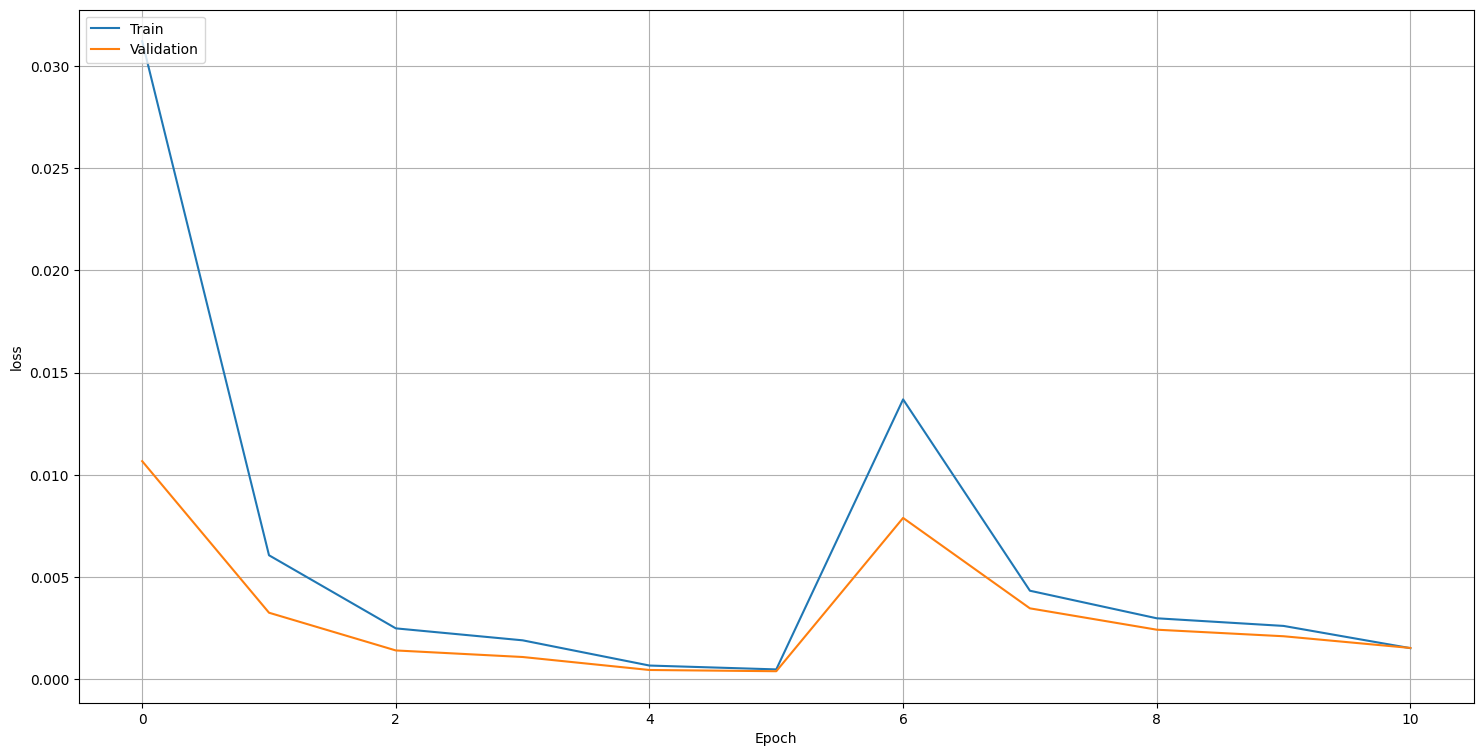

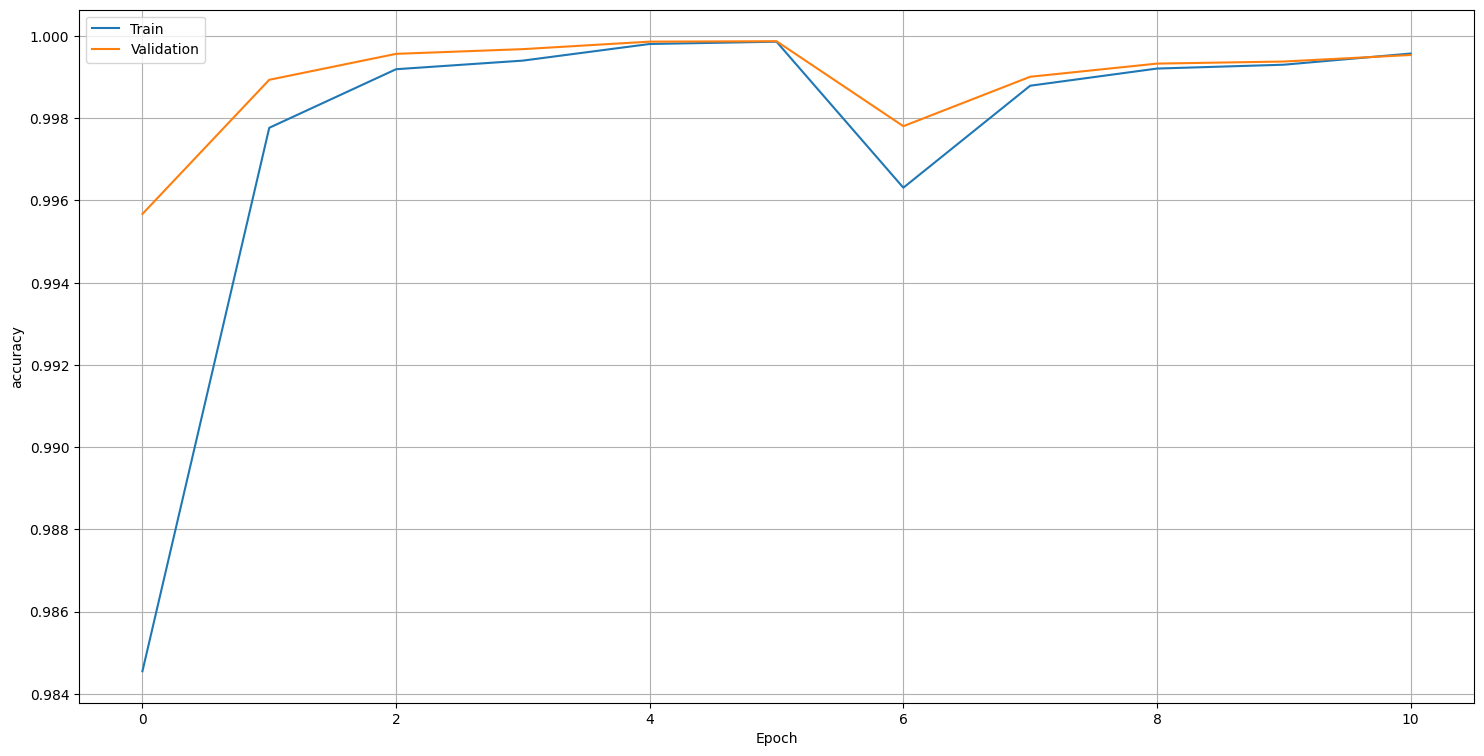

In [33]:
plot_training_history(history, "loss")
plot_training_history(history, "accuracy")

In [34]:
def visualize_cranium_predictions(predictions, ground_truth, slice_idx=150):
    """Visualize cranium segmentation results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(test_GT[0][:, :, slice_idx])
    axes[0].set_title('Original scan')
    axes[0].axis('off')

    axes[1].imshow(predictions[0][:, :, slice_idx])
    axes[1].set_title('Model prediction')
    axes[1].axis('off')

    gt_display = np.where(ground_truth[0][:, :, slice_idx] >= 10, 1, 0)
    axes[2].imshow(gt_display)
    axes[2].set_title('Ground truth')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

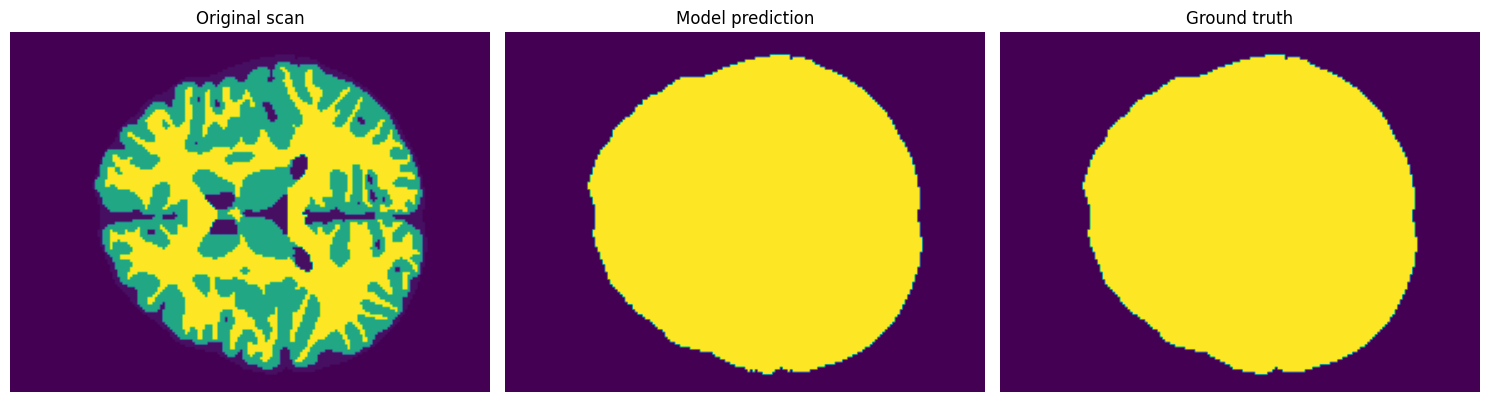

In [35]:
visualize_cranium_predictions(predictions, test_GT)

# Step 6: Brain-skull segmentation, second U-Net

For this part, Adam optimizer with a learning rate of 2e-4 gave better results. The processing steps remain largely the same as before, with minor adjustments to channels and conditions.

In [36]:
def prepare_second_stage_data(t1_data, t2_data, gt_data, skull_predictions, num_slices, height, width):
    """Prepare training data for the second U-Net"""
    X = np.zeros((num_slices, height, width, 3))  # 3 channels: T1, T2, and skull mask
    Y = np.zeros((num_slices, height, width, 1))  # Target: grey matter

    n = 0
    for t1, t2, gt, skull in zip(t1_data, t2_data, gt_data, skull_predictions):
        for z in range(gt.shape[2]):
            if np.sum(gt[:,:,z] > 0) > 100:
                X[n,:,:,0] = t1[:,:,z]
                X[n,:,:,1] = t2[:,:,z]
                X[n,:,:,2] = skull[:,:,z]
                Y[n,:,:,0] = (gt[:,:,z] >= 150).astype(float)  # grey matter
                n += 1
    return X, Y

In [37]:
X_train_2, Y_train_2 = prepare_second_stage_data(
    train_t1, train_t2, train_GT, predictions,
    nb_slices_train, height, width
)
X_val_2, Y_val_2 = prepare_second_stage_data(
    val_t1, val_t2, val_GT, predictions,
    nb_slices_val, height, width
)

In [38]:
print("Creating second U-Net model")
unet_model_2 = create_unet(input_size = (144,192,3), lr = 2e-4)

Creating second U-Net model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 144, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 144, 192, 8)    │            224 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 144, 192, 8)    │            584 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 72, 96, 8)      │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 72, 96, 16)     │          1,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 72, 96, 16)     │          2,320 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 36, 48, 16)     │              0 │ conv2d_27[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 36, 48, 32)     │          4,640 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 36, 48, 32)     │          9,248 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 18, 24, 32)     │              0 │ conv2d_29[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 18, 24, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 18, 24, 64)     │         36,928 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 18, 24, 64)     │              0 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 9, 12, 64)      │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 9, 12, 128)     │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 9, 12, 128)     │        147,584 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 9, 12, 128)     │              0 │ conv2d_33[0][0]        │
├──────────────────────

 Total params: 485,957 (1.85 MB)

 Trainable params: 485,957 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True,
    verbose=1,
    patience=10
)

In [40]:
print("Training second U-Net model")

with tf.device('/device:GPU:0'):
    history_2 = unet_model_2.fit(
        X_train_2, Y_train_2,
        batch_size=2,
        epochs=100,
        verbose=1,
        shuffle=True,
        validation_data=(X_val_2, Y_val_2),
        callbacks=[early_stopping]
    )

Training second U-Net model
Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.9553 - loss: 0.6646 - val_accuracy: 0.9686 - val_loss: 0.5706
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9893 - loss: 0.6174 - val_accuracy: 0.9769 - val_loss: 0.5314
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9930 - loss: 0.5919 - val_accuracy: 0.9780 - val_loss: 0.5078
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9938 - loss: 0.5666 - val_accuracy: 0.9830 - val_loss: 0.4798
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9944 - loss: 0.5368 - val_accuracy: 0.9844 - val_loss: 0.4590
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9945 - loss: 0.5186 - val_accuracy: 0.9849 - val_loss: 0.4397
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9951 - loss: 0.4911 - val_accuracy: 0.9847 - val_loss: 0.4219
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.

In [41]:
unet_model_2.save("/content/drive/My Drive/health/final_best_unet_model_2.h5")

In [42]:
def predict_grey_matter(t1_data, t2_data, skull_predictions, model):
    """Generate grey matter predictions using the second U-Net"""
    predictions = []

    for t1, t2, skull in zip(t1_data, t2_data, skull_predictions):
        height, width, depth = t1.shape
        prediction_volume = np.zeros((height, width, depth))

        for z in range(depth):
            if np.sum(skull[:,:,z]) > 0:  # only if there is skull here
                slice_input = np.zeros((1, height, width, 3))
                slice_input[0,:,:,0] = t1[:,:,z]
                slice_input[0,:,:,1] = t2[:,:,z]
                slice_input[0,:,:,2] = skull[:,:,z]

                prediction = model.predict(slice_input, verbose=0)
                prediction_volume[:,:,z] = (prediction[0,:,:,0] > 0.5).astype(float)

        predictions.append(prediction_volume)

    return predictions

## Dice coefficient for the second model

In [43]:
predictions_2 = predict_grey_matter(test_t1, test_t2, predictions, unet_model_2)
dice_score_gm = compute_dice_coef(predictions_2[0], np.where(test_GT[0] >= 150, 1, 0))

print(f"Dice coefficient for grey matter segmentation: {dice_score_gm:.4f}")

Dice coefficient for grey matter segmentation: 0.9707


## Perf. visualization

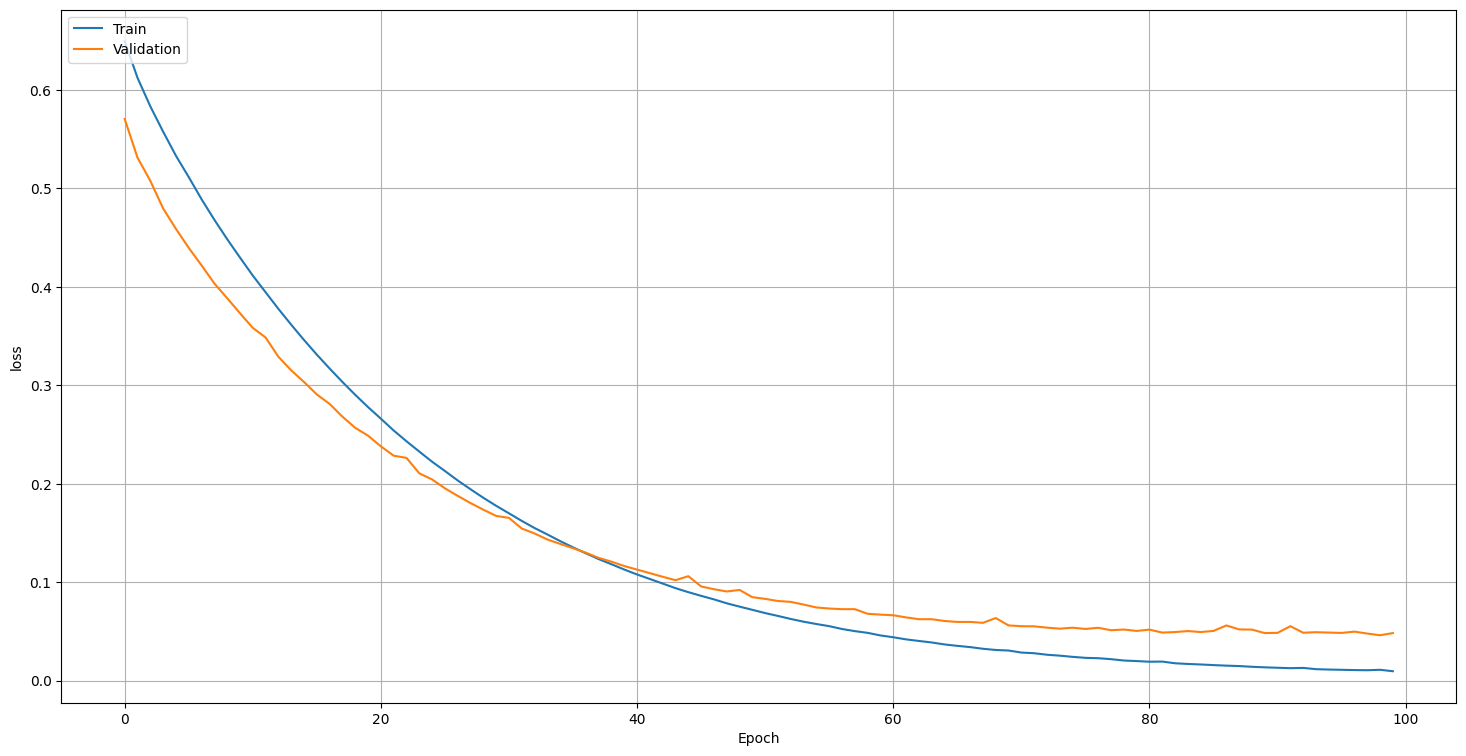

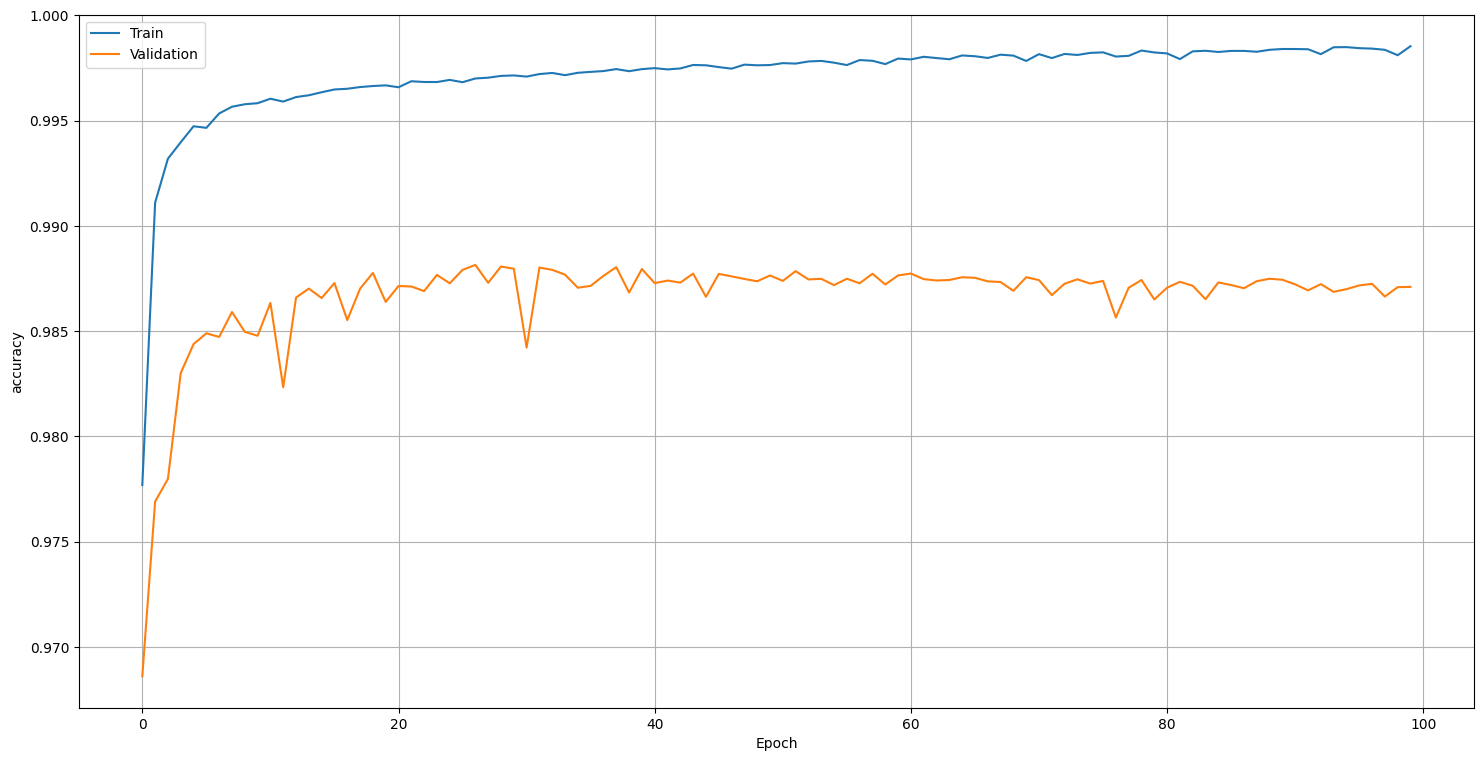

In [44]:
plot_training_history(history_2, "loss")
plot_training_history(history_2, "accuracy")

In [45]:
def plot_grey_matter_results(predictions, ground_truth, slice_idx=150):
    """Visualize grey matter segmentation results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(predictions[0][:,:,slice_idx])
    axes[0].set_title('Predicted Grey Matter')
    axes[0].axis('off')

    axes[1].imshow(np.where(ground_truth[0][:,:,slice_idx] >= 150, 1, 0))
    axes[1].set_title('Ground Truth Grey Matter')
    axes[1].axis('off')

    axes[2].imshow(ground_truth[0][:,:,slice_idx])
    axes[2].set_title('Original Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

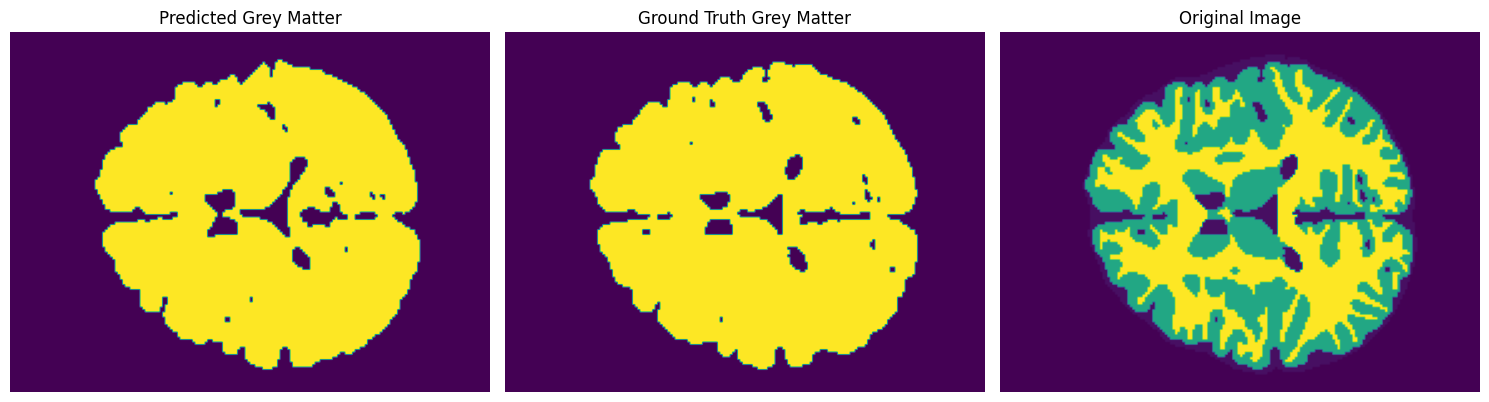

In [46]:
plot_grey_matter_results(predictions_2, test_GT)

# Step 7: White Matter Segmentation - Third U-Net

This time, Adam optimizer with learning_rate = 1e-3 gives the best dice coef results.

In [47]:
def prepare_third_stage_data(t1_data, t2_data, gt_data, skull_pred, gm_pred, num_slices, height, width):
    X = np.zeros((num_slices, height, width, 4))
    Y = np.zeros((num_slices, height, width, 1))  # white matter target

    n = 0
    for t1, t2, gt, skull, gm in zip(t1_data, t2_data, gt_data, skull_pred, gm_pred):
        gt_wm = np.where(gt >= 250, 1, 0)  # white matter ground truth

        for z in range(gt.shape[2]):
            if np.sum(gt[:,:,z] > 0) > 100:
                X[n,:,:,0] = t1[:,:,z]
                X[n,:,:,1] = t2[:,:,z]
                X[n,:,:,2] = skull[:,:,z]
                X[n,:,:,3] = gm[:,:,z]
                Y[n,:,:,0] = gt_wm[:,:,z]
                n += 1

    return X, Y

In [48]:
X_train_3, Y_train_3 = prepare_third_stage_data(
    train_t1, train_t2, train_GT,
    predictions, predictions_2,
    nb_slices_train, height, width
)

X_val_3, Y_val_3 = prepare_third_stage_data(
    val_t1, val_t2, val_GT,
    predictions, predictions_2,
    nb_slices_val, height, width
)

In [49]:
print("Creating third U-Net model")
unet_model_3 = create_unet(input_size=(144,192,4), lr=1e-3)

Creating third U-Net model


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 144, 192, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 144, 192, 8)    │            296 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 144, 192, 8)    │            584 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 72, 96, 8)      │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 72, 96, 16)     │          1,168 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 72, 96, 16)     │          2,320 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 36, 48, 16)     │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 36, 48, 32)     │          4,640 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 36, 48, 32)     │          9,248 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 18, 24, 32)     │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 18, 24, 64)     │         18,496 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 18, 24, 64)     │         36,928 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 18, 24, 64)     │              0 │ conv2d_55[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 9, 12, 64)      │              0 │ dropout_4[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 9, 12, 128)     │         73,856 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 9, 12, 128)     │        147,584 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 9, 12, 128)     │              0 │ conv2d_57[0][0]        │
├──────────────────────

 Total params: 486,029 (1.85 MB)

 Trainable params: 486,029 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True,
    verbose=1,
    patience=10
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

In [51]:
print("Training third U-Net model")
with tf.device('/device:GPU:0'):
    history_3 = unet_model_3.fit(
        X_train_3, Y_train_3,
        batch_size=1,
        epochs=100,
        verbose=1,
        shuffle=True,
        validation_data=(X_val_3, Y_val_3),
        callbacks=[early_stopping, lr_scheduler]
    )

Training third U-Net model
Epoch 1/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9676 - loss: 0.6571 - val_accuracy: 0.9122 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 2/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9688 - loss: 0.0507 - val_accuracy: 0.9276 - val_loss: 0.1322 - learning_rate: 0.0010
Epoch 3/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9724 - loss: 0.0513 - val_accuracy: 0.9382 - val_loss: 0.1317 - learning_rate: 0.0010
Epoch 4/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9781 - loss: 0.0463 - val_accuracy: 0.9462 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 5/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9825 - loss: 0.0384 - val_accuracy: 0.9514 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 6/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9804 - loss: 0.0421 - val_accuracy: 0.9376 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 7/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step 

In [52]:
def predict_white_matter(t1_data, t2_data, skull_pred, gm_pred, model):
    """Generate white matter predictions using the third U-Net"""
    predictions = []

    for t1, t2, skull, gm in zip(t1_data, t2_data, skull_pred, gm_pred):
        height, width, depth = t1.shape
        prediction_volume = np.zeros((height, width, depth))

        for z in range(depth):
            if np.sum(skull[:,:,z]) > 0:  # Only predict if there's skull content
                slice_input = np.zeros((1, height, width, 4))
                slice_input[0,:,:,0] = t1[:,:,z]
                slice_input[0,:,:,1] = t2[:,:,z]
                slice_input[0,:,:,2] = skull[:,:,z]
                slice_input[0,:,:,3] = gm[:,:,z]

                prediction = model.predict(slice_input, verbose=0)
                prediction_volume[:,:,z] = (prediction[0,:,:,0] > 0.5).astype(float)

        predictions.append(prediction_volume)

    return predictions

In [53]:
unet_model_3.save("/content/drive/My Drive/health/final_best_unet_model_3.h5")

## Dice coefficient for the third model

In [54]:
predictions_3 = predict_white_matter(
    test_t1, test_t2,
    predictions, predictions_2,
    unet_model_3
)

dice_score_wm = compute_dice_coef(
    predictions_3[0],
    np.where(test_GT[0] >= 250, 1, 0)
)
print(f"Dice coefficient for white matter segmentation: {dice_score_wm:.4f}")

Dice coefficient for white matter segmentation: 0.8119


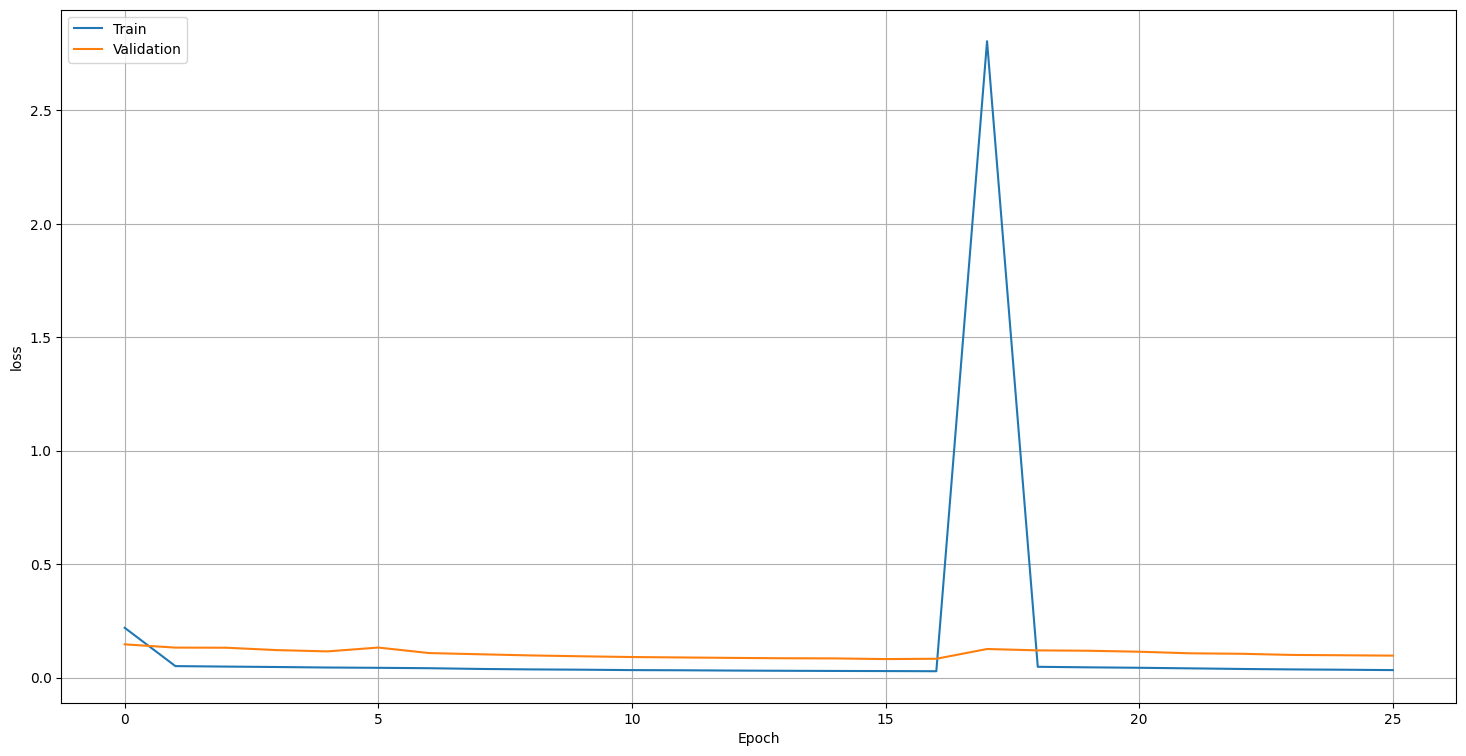

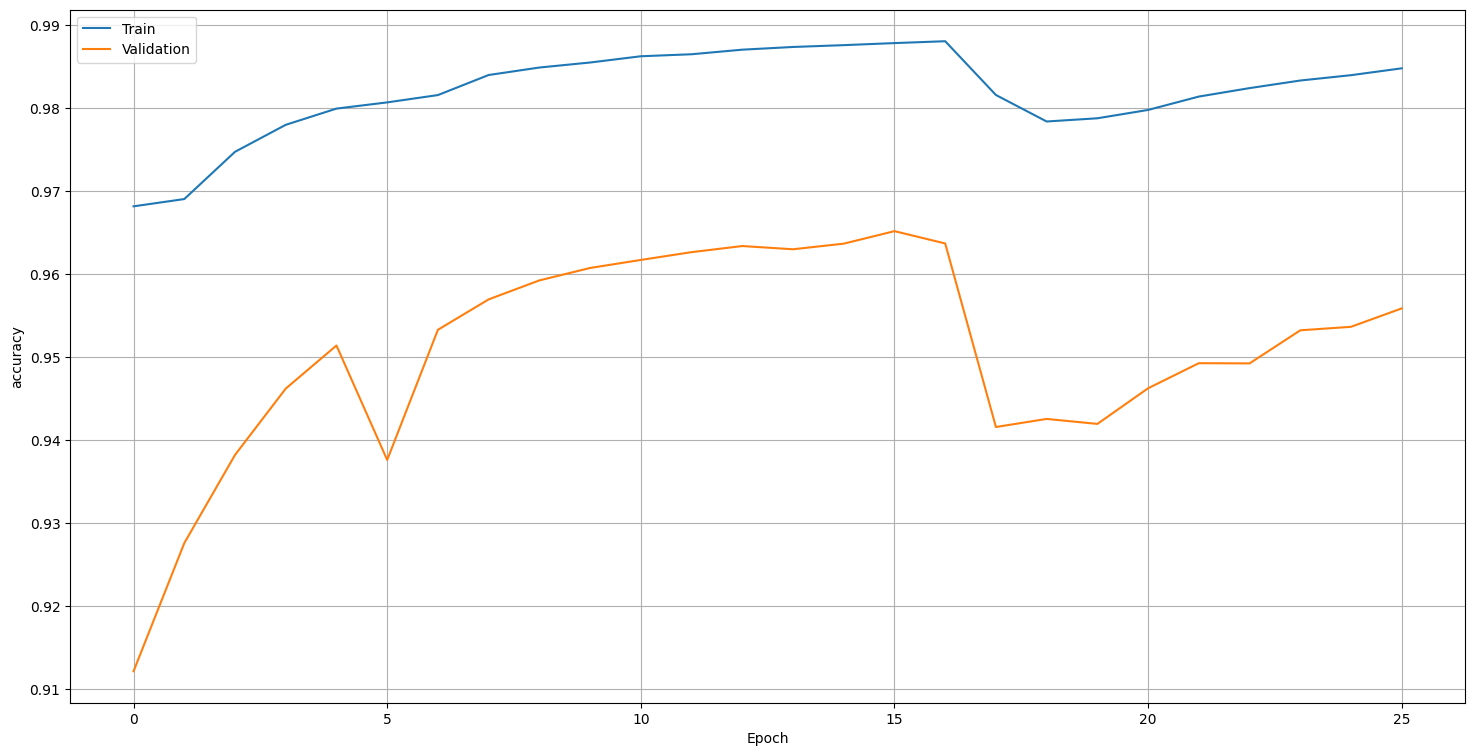

In [55]:
plot_training_history(history_3, "loss")
plot_training_history(history_3, "accuracy")

In [56]:
def plot_grey_matter_results(predictions, ground_truth, slice_idx=150):
    """Visualize grey matter segmentation results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(predictions[0][:,:,slice_idx])
    axes[0].set_title('Predicted Grey Matter')
    axes[0].axis('off')

    axes[1].imshow(np.where(ground_truth[0][:,:,slice_idx] >= 250, 1, 0))
    axes[1].set_title('Ground Truth Grey Matter')
    axes[1].axis('off')

    axes[2].imshow(ground_truth[0][:,:,slice_idx])
    axes[2].set_title('Original Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

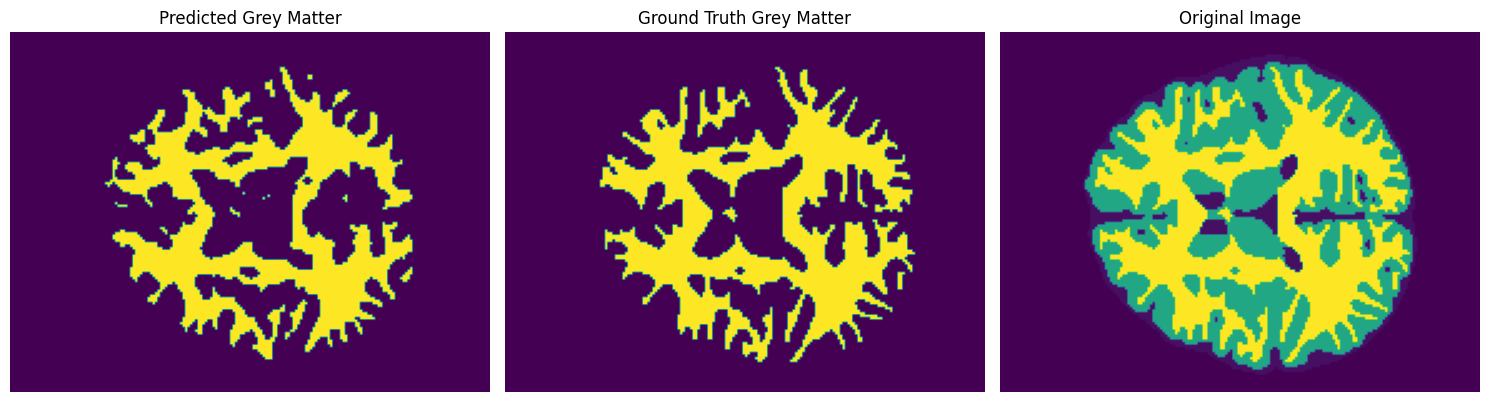

In [57]:
plot_grey_matter_results(predictions_3, test_GT)

# Final step: final prediction

Once the binary predictions of the three networks are obtained, they are combined to generate the final file using the following formula:

```
prediction = 10 * prediction_10 + 140 * prediction_150 + 100 * prediction_250
```

In [58]:
def reconstruct_final_segmentation(skull_pred, gm_pred, wm_pred):
    return (
        10 * skull_pred +
        140 * gm_pred +
        100 * wm_pred
    )

In [59]:
final_predictions = []

for skull, gm, wm in zip(predictions, predictions_2, predictions_3):
    final_pred = reconstruct_final_segmentation(skull, gm, wm)
    final_predictions.append(final_pred)

## Perf. visualization

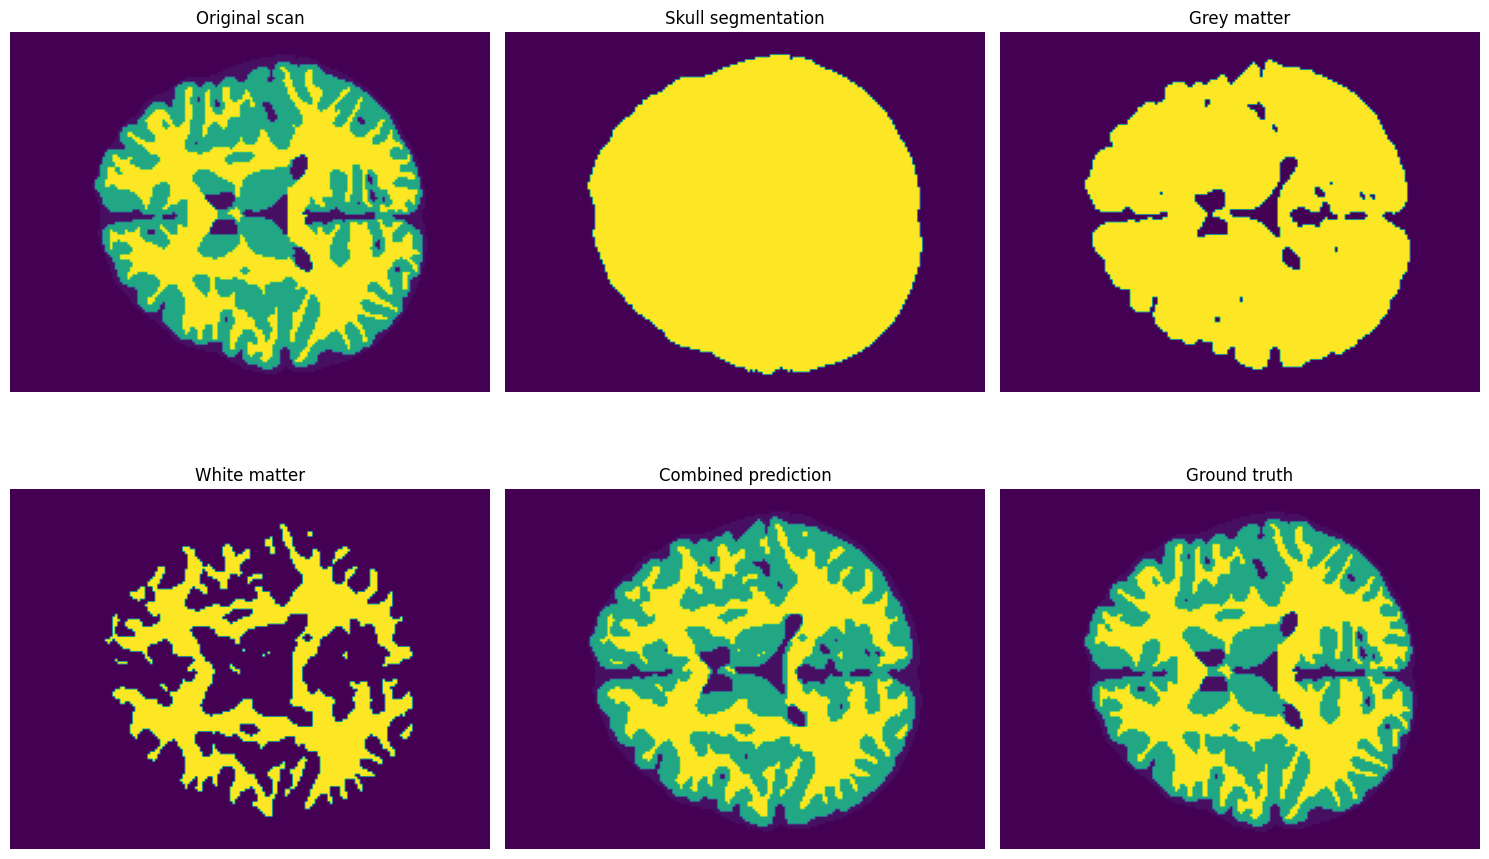

In [63]:
def plot_segmentation_results(predictions, ground_truth, slice_idx=150):
    """Plot full segmentation results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0,0].imshow(ground_truth[0][:,:,slice_idx])
    axes[0,0].set_title('Original scan')
    axes[0,0].axis('off')

    axes[0,1].imshow(predictions[0][:,:,slice_idx])
    axes[0,1].set_title('Skull segmentation')
    axes[0,1].axis('off')

    axes[0,2].imshow(predictions_2[0][:,:,slice_idx])
    axes[0,2].set_title('Grey matter')
    axes[0,2].axis('off')

    axes[1,0].imshow(predictions_3[0][:,:,slice_idx])
    axes[1,0].set_title('White matter')
    axes[1,0].axis('off')

    axes[1,1].imshow(final_predictions[0][:,:,slice_idx])
    axes[1,1].set_title('Combined prediction')
    axes[1,1].axis('off')

    axes[1,2].imshow(ground_truth[0][:,:,slice_idx])
    axes[1,2].set_title('Ground truth')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

plot_segmentation_results(predictions, test_GT)

In [65]:
print("Recap dice coefficients:")
print(f"Skull segmentation: {dice_score_sk:.4f}")
print(f"Grey matter segmentation: {dice_score_gm:.4f}")
print(f"White matter segmentation: {dice_score_wm:.4f}")

Recap dice coefficients:
Skull segmentation: 0.9998
Grey matter segmentation: 0.9707
White matter segmentation: 0.8119


# Conclusion

![Reults](visualizations/results.gif)

The final results show visual similarities for each segmentation. As we can see with the final dice coefficients, the model excels at skull and grey matter segmentation, achieving near-perfect accuracy for skull detection and very high accuracy for grey matter. The lower performance on white matter segmentation (0.8119) reflects the difficulty in identifying these tissues, as white matter boundaries are more subtle and complex to detect in MRI scans.

These results demonstrate the effectiveness of the cascading U-Net architecture for automated brain tissue segmentation.

Thank you for reading my notebook!
